In [21]:
import requests
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# from tensorflow.keras import datasets, layers, models
# import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [22]:
data = pd.read_csv('data/data.csv', parse_dates=['kickoff_time'])

In [50]:
cutoff = 30

data_mid = data[data['position'] == 'MID'].reset_index(drop=True)

train_data = data_mid[data_mid['round'] < cutoff].drop('round', axis=1)
test_data = data_mid[data_mid['round'] >= cutoff].drop('round', axis=1)



wrangling_columns = ['element']

no_scaling = [
    'was_home', 'clean_sheets', 'yellow_cards', 'red_cards',
    'starts']

bounded_vars = ['minutes', 'bonus']  # minmax scaling

out_metrics = [
    'penalties_missed', 'goals_scored', 'assists', 'expected_goals',
    'expected_assists', 'expected_goal_involvements']

gkp_metrics = ['penalties_saved', 'saves']

count_vars = ['goals_conceded', 'own_goals']

fantasy_metrics = [
    'bps', 'influence', 'creativity', 'threat', 'ict_index', 'value',
    'transfers_balance', 'selected', 'transfers_in', 'transfers_out', 'total_points']

x_metrics = ['expected_goals_conceded']

time_metrics = ['time_diffs']

In [51]:
scaler = MinMaxScaler().set_output(transform='pandas')

min_max_vars = bounded_vars + out_metrics + count_vars + fantasy_metrics + x_metrics + time_metrics

scaler.fit(train_data[min_max_vars])
train_data = train_data[no_scaling + wrangling_columns].join(scaler.transform(train_data[min_max_vars]))
test_data = test_data[no_scaling + wrangling_columns].join(scaler.transform(test_data[min_max_vars]))

In [154]:
window_size = 6

def get_window_arrays(data):

    X, y = [], []
    for player in tqdm(data['element'].unique(), desc='creating frames'):

        player_data = data[
            data['element'] == player].drop('element', axis=1).reset_index(
            drop=True).copy()

        frame_generator = player_data.drop(
            player_data.tail(1).index).rolling(window=window_size)

        for window in frame_generator:

            if len(window) >= window_size:
                X.append(np.array(window, float))

                points_index = window.index[-1]

                y.append(player_data['total_points'].loc[points_index + 1])

    return np.array(X), np.array(y, float)

X_train, y_train = get_window_arrays(train_data)
X_test, y_test = get_window_arrays(test_data)

np.save('data/X_train', X_train)
np.save('data/y_train', y_train)
np.save('data/X_test', X_test)
np.save('data/y_test', y_test)


creating frames:   0%|          | 0/251 [00:00<?, ?it/s]

creating frames:   0%|          | 0/204 [00:00<?, ?it/s]

In [155]:
np.load('data/X_test.npy').shape

(315, 6, 28)

In [57]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 101s 1us/step


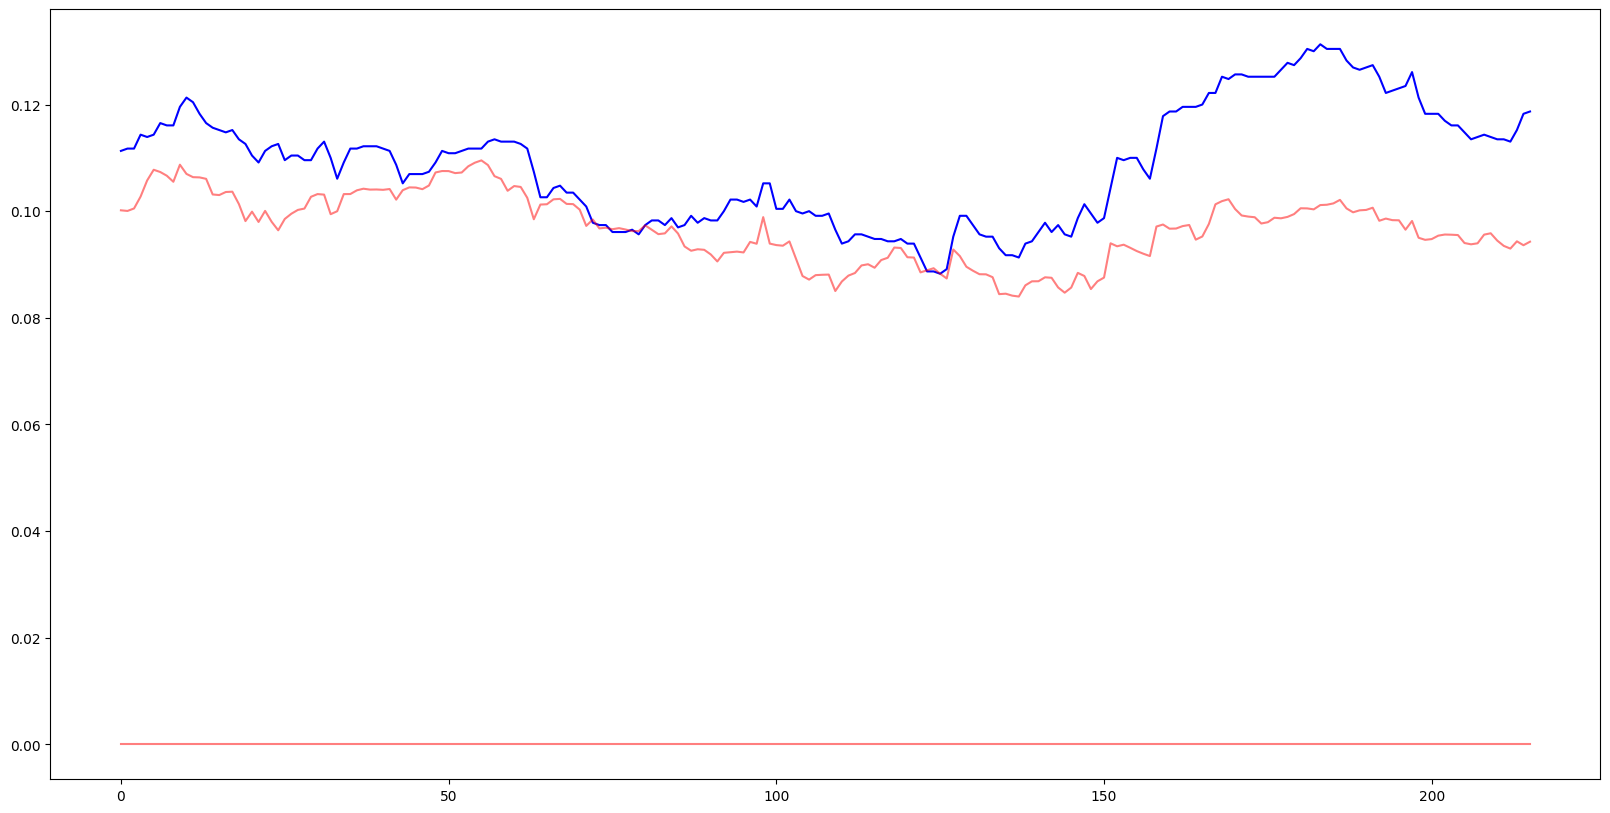

In [184]:
def moving_average(a, n=100) :
    ret = np.cumsum(np.abs(a), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.figure(figsize=(20,10))

plt.plot(moving_average(np.roll(y_test, 1)-y_test), 'b')
plt.plot(moving_average(preds-y_test), 'r', alpha=0.5)
plt.plot(moving_average(y_test-y_test), 'r', alpha=0.5)

plt.show()

In [182]:
window_size = 6

model = models.Sequential()
model.add(layers.Conv1D(filters=28, kernel_size=2, activation='relu', input_shape=(window_size, 28)))
model.add(layers.Conv1D(filters=28, kernel_size=2, activation='relu'))
model.add(layers.Conv1D(filters=28, kernel_size=2, activation='relu'))
model.add(layers.Conv1D(filters=100, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y_train, epochs=200, verbose=0)
preds = np.transpose(model.predict(X_test))[0]

10/10 [==============================] - 0s 888us/step


In [159]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 5, 28)             1596      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 28)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 56)                0         
                                                                 
 dense_2 (Dense)             (None, 100)               5700      
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 7,397
Trainable params: 7,397
Non-trainable params: 0
____________________________________________________

10/10 [==============================] - 0s 888us/step


In [64]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

<Axes: xlabel='creativity', ylabel='total_points'>

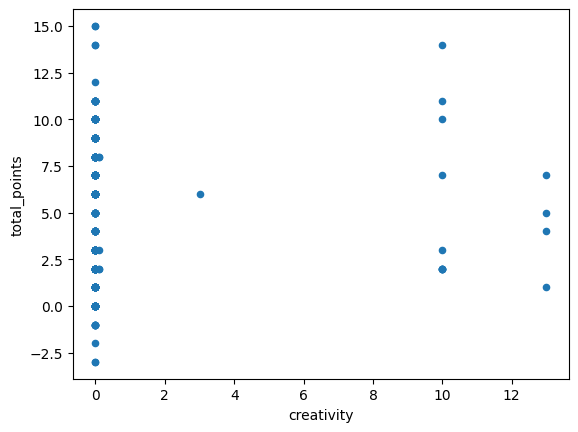

In [5]:
data[(data['position'] == 'GKP') & (data['minutes'] >= 0)].plot.scatter(x='creativity', y='total_points')

<Axes: ylabel='Frequency'>

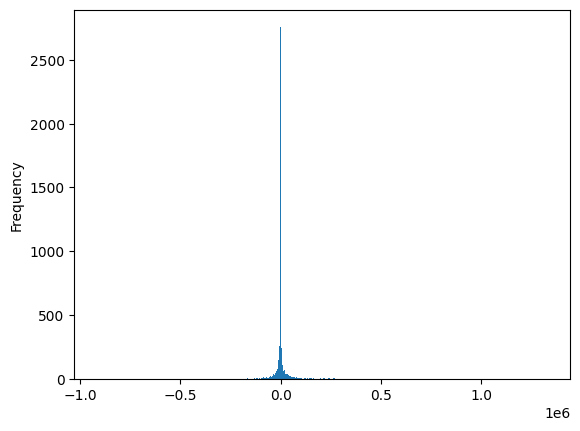

In [28]:
total_points = data['transfers_balance']

total_points.plot.hist(bins=1000)